##Google Colab

Mounting the dataset from GoogleDrive

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
%cd /gdrive/My Drive/Colab Notebooks/Challenge/Challenge_1/training_dataset_homework1

/gdrive/My Drive/Colab Notebooks/Challenge/Challenge_1/training_dataset_homework1


##Import Libraries

In [ ]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from PIL import Image
from sklearn.model_selection import KFold
from pathlib import Path
from shutil import copyfile

# Download and import visualkeras library
!pip install visualkeras
import visualkeras

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix

tfk = tf.keras
tfkl = tf.keras.layers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 989 kB 3.8 MB/s 


##Set seed for reproducibility

In [ ]:
# Random seed for reproducibility
seed = 42 

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

##Data Loader

Firstly, we create an instance of labels:

In [ ]:
decide_class_indices = True
if decide_class_indices:
    labels = ['Species1',                    # 0
               'Species2',                   # 1
               'Species3',                   # 2
               'Species4',                   # 3
               'Species5',                   # 4
               'Species6',                   # 5
               'Species7',                   # 6
               'Species8'                   # 7
             ]                
else:
    classes=None

We unzip the dataset to be used for classification and we set the dataset directory:

In [ ]:
#!unzip training_dataset_homework1.zip

In [ ]:
dataset_dir = 'training_data_final'

In order to proceed with the analysis we decide to split the given dataset of images into two folders, one for training and one for validation, corresponding respectively to 80%-20% of the whole dataset.

In [ ]:
training_size = 0.8
test_size = 0.2
seed = 42
training_set = []
validation_set = []
test_set = []

img_names = []
corresponding_labels = []


#Load images
for label in labels:
    class_imgs= next(os.walk('{}/{}/'.format(dataset_dir,label)))[2]
    for img in class_imgs:
        img_names.append('{}/{}/{}'.format(dataset_dir,label,img))
        corresponding_labels.append(label)

image_train,image_val,mask_train,mask_val = train_test_split(img_names, corresponding_labels, test_size=test_size, random_state=seed,  stratify=corresponding_labels,shuffle=True)

In order to make the splits, we first create the two corresponding different folders for train and validation, and we load the images on them:

In [ ]:
##                          !!!!!!!!!!!!!!!!!!!!  ONLY DO IF YOU WANT TO REMAKE THE SPLITS !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!1
#import shutil

#str_dataset_folder = os.getcwd() + '/stratified_dataset'

#str_train_folder = '{}/train'.format(str_dataset_folder)
#str_val_folder = '{}/validation'.format(str_dataset_folder)

#if os.path.exists(str_dataset_folder):
#    shutil.rmtree(str_dataset_folder, ignore_errors=True)

#os.mkdir(str_dataset_folder)
#os.mkdir(str_train_folder)
#os.mkdir(str_val_folder)

#for class_name in labels:
#    os.mkdir(str_train_folder+'/'+class_name)
#    os.mkdir(str_val_folder+'/'+class_name)

#print('copying from original dataset to the new dataset...')

#for file in image_train:
#    src = file
#    dst =  '{}/{}/{}'.format(str_train_folder,file.split('/')[-2],file.split('/')[-1])
#    if os.path.exists(src):
#        shutil.copyfile(src,dst)
#print('training set has been created')

#for file in image_val:
#    src = file
#    dst = '{}/{}/{}'.format(str_val_folder,file.split('/')[-2],file.split('/')[-1])
#    if os.path.exists(src):
#        shutil.copyfile(src,dst)    
#print('validation set has been created')

We set the train and validation folder directory:

In [ ]:
str_dataset_folder = os.getcwd() + '/stratified_dataset'

str_train_folder = '{}/train'.format(str_dataset_folder)
str_val_folder = '{}/validation'.format(str_dataset_folder)

##Data Augmentation

Since the images are divided into folders, one for each class, we can exploit the ImageDataGenerator to read them from disk:

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#Training set with rescaling in range [0,1], rotation, shifts, flips, zome and filling:
train = ImageDataGenerator( rescale=1/255.,
                            shear_range=0.2,
                            rotation_range=45,
                            height_shift_range=50,
                            width_shift_range=50,
                            zoom_range=0.3,
                            horizontal_flip=True,
                            vertical_flip=True,
                            fill_mode='reflect'
                           )

train = train.flow_from_directory(  str_train_folder,
                                    target_size=(256,256),
                                    color_mode='rgb',
                                    class_mode='categorical',
                                    batch_size=16,
                                    shuffle=True,
                                    seed=seed)

#Validation
val = ImageDataGenerator( rescale=1/255.
                         )

val = val.flow_from_directory( str_val_folder,
                               target_size=(256,256),
                               color_mode='rgb',
                               class_mode='categorical',
                               batch_size=16,
                               shuffle=True,
                               seed=seed)

Found 2833 images belonging to 8 classes.
Found 709 images belonging to 8 classes.


We check if the augmentation is well implemented:

In [ ]:
def get_next_batch(generator):
  labels = [
    'Species1',
    'Species2',
    'Species3',
    'Species4',
    'Species5',
    'Species6',
    'Species7',
    'Species8'
]

  batch = next(generator)

  image = batch[0]
  target = batch[1]

  print("(Input) image shape:", image.shape)
  print("Target shape:",target.shape)

  # Visualize only the first sample
  image = image[0]
  target = target[0]
  target_idx = np.argmax(target)
  print("Categorical label:", target)
  print("Label:", target_idx)
  print("Class name:", labels[target_idx])
  fig = plt.figure(figsize=(6, 4))
  plt.imshow(np.uint8(image))

  return batch

(Input) image shape: (16, 256, 256, 3)
Target shape: (16, 8)
Categorical label: [0. 0. 0. 1. 0. 0. 0. 0.]
Label: 3
Class name: Species4


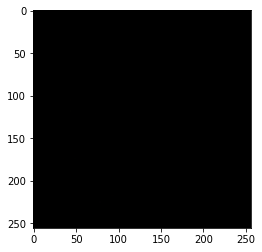

In [ ]:
# Get a sample from dataset and show info
_ = get_next_batch(val)

The image is black due to the normalization [0,1].

##Transfer Learning

We take the weights pre-trained on ImageNet of Xception architecture:

83683744/83683744 [==============================] - 3s 0us/step
Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 127, 127, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 127, 127, 32  128        ['block1_conv1[0][0]']           
 ation)                   

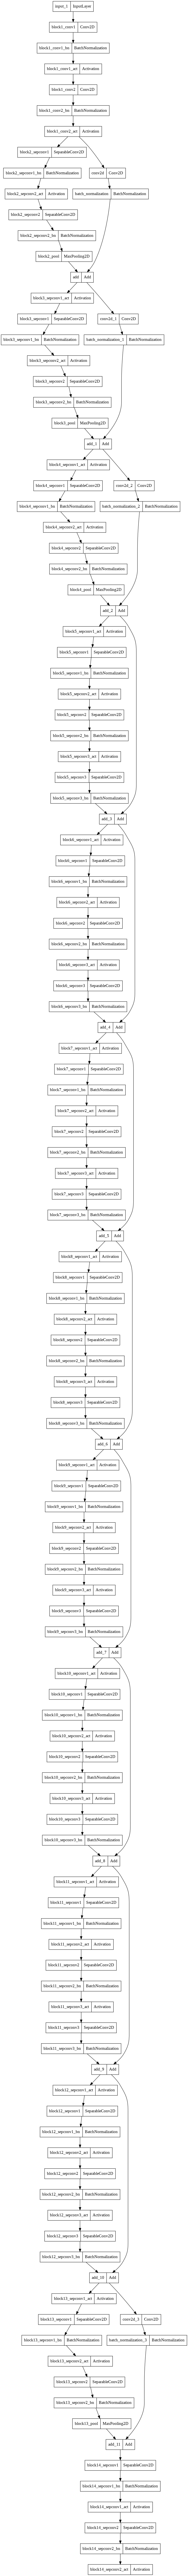

In [ ]:
input_shape = (256, 256, 3)
supernet = tf.keras.applications.Xception( include_top=False,
                                        weights="imagenet",
                                        input_shape=input_shape
                                        )
supernet.summary()
tfk.utils.plot_model(supernet)

We build our custom neural network:

In [ ]:
def build_model(input_shape):
    supernet.trainable=False
    model = tfk.Sequential()
    model.add(supernet)

    model.add(tfkl.Conv2D(128, (3, 3), padding="same"))
    model.add(tfkl.Activation("relu"))

    model.add(tfkl.BatchNormalization(axis=-1))
    model.add(tfkl.MaxPooling2D(pool_size=(2, 2)))
    model.add(tfkl.Dropout(0.2, seed=seed))
    model.add(tfkl.Flatten())

    model.add(tfkl.Dense(units=256,kernel_initializer = tfk.initializers.GlorotUniform(seed)))
    model.add(tfkl.Activation("relu"))

    model.add(tfkl.BatchNormalization())
    model.add(tfkl.Dropout(0.2, seed=seed))

    model.add(tfkl.Dense(units=8, activation="softmax",kernel_initializer = tfk.initializers.GlorotUniform(seed)))

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

We define the input shape and we build the model:

In [ ]:
input_shape = (256, 256, 3)

tl_model = build_model(input_shape)
tl_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 8, 8, 2048)        20861480  
                                                                 
 conv2d_4 (Conv2D)           (None, 8, 8, 128)         2359424   
                                                                 
 activation (Activation)     (None, 8, 8, 128)         0         
                                                                 
 batch_normalization_4 (Batc  (None, 8, 8, 128)        512       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 4, 4, 128)        0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 4, 4, 128)         0

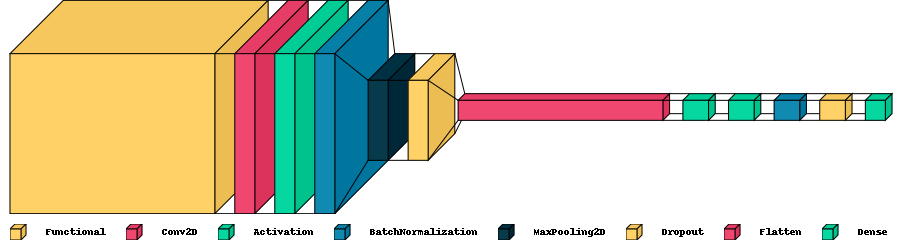

In [ ]:
visualkeras.layered_view(tl_model, legend=True, spacing=20, scale_xy=20)

We train the model on 50 epochs using EarlyStopping to prevent overfitting by monitoring validation accuracy in order to maximize it:

In [ ]:
epochs = 50

tl_history = tl_model.fit(
    x=train,
    epochs = epochs,
    validation_data = val,
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True)]
).history

Epoch 1/50
178/178 [==============================] - 1552s 9s/step - loss: 1.9235 - accuracy: 0.3826 - val_loss: 1.4175 - val_accuracy: 0.5148
Epoch 2/50
178/178 [==============================] - 51s 288ms/step - loss: 1.4780 - accuracy: 0.4681 - val_loss: 1.4018 - val_accuracy: 0.5176
Epoch 3/50
178/178 [==============================] - 52s 294ms/step - loss: 1.3609 - accuracy: 0.5044 - val_loss: 1.1775 - val_accuracy: 0.5867
Epoch 4/50
178/178 [==============================] - 51s 288ms/step - loss: 1.2506 - accuracy: 0.5450 - val_loss: 1.0148 - val_accuracy: 0.6474
Epoch 5/50
178/178 [==============================] - 51s 286ms/step - loss: 1.1994 - accuracy: 0.5690 - val_loss: 1.0402 - val_accuracy: 0.6361
Epoch 6/50
178/178 [==============================] - 51s 286ms/step - loss: 1.1429 - accuracy: 0.5754 - val_loss: 1.0495 - val_accuracy: 0.6389
Epoch 7/50
178/178 [==============================] - 51s 287ms/step - loss: 1.1351 - accuracy: 0.5930 - val_loss: 1.0093 - val_acc

We plot the Validation Loss and Validation accuracy:

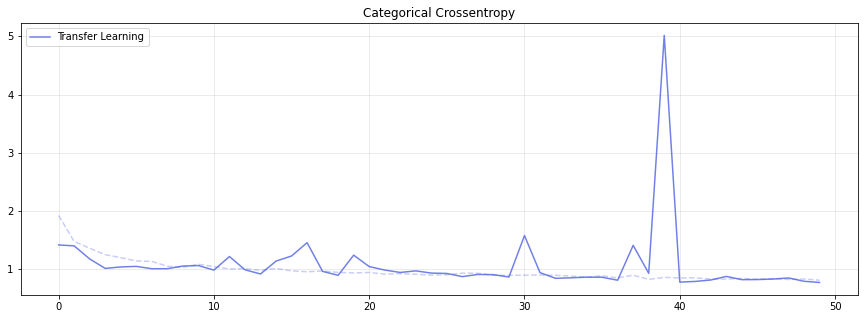

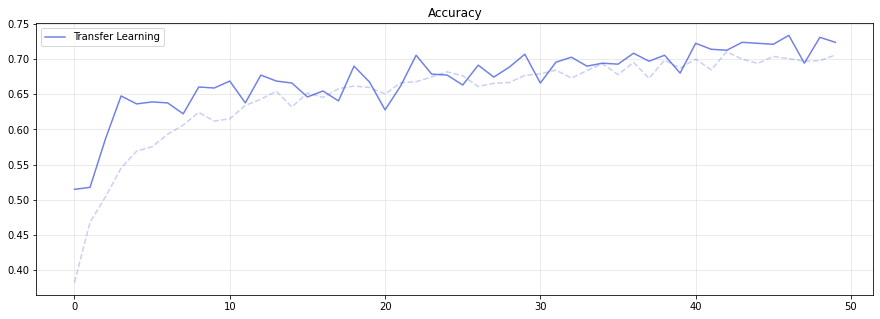

In [ ]:
# Plot the training
plt.figure(figsize=(15,5))
plt.plot(tl_history['loss'], alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_loss'], label='Transfer Learning', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(tl_history['accuracy'], alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_accuracy'], label='Transfer Learning', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

The validation accuracy of our model on TransferLearning is:

In [ ]:
tl_model.evaluate(val, return_dict=True)

45/45 [==============================] - 4s 88ms/step - loss: 0.7738 - accuracy: 0.7236


{'loss': 0.7737872004508972, 'accuracy': 0.7235543131828308}

We save our model:

In [ ]:
tl_model.save('Xception_TransferLearningModel')

##Fine Tuning

After Trasnfer Learning, we improve the perfomances of our model using Fine Tuning.

In [ ]:
# Re-load the model after transfer learning
ft_model = tfk.models.load_model('Xception_TransferLearningModel')
ft_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 8, 8, 2048)        20861480  
                                                                 
 conv2d_4 (Conv2D)           (None, 8, 8, 128)         2359424   
                                                                 
 activation (Activation)     (None, 8, 8, 128)         0         
                                                                 
 batch_normalization_4 (Batc  (None, 8, 8, 128)        512       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 4, 4, 128)        0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 4, 4, 128)         0

We set all Xception's layers to True:

In [ ]:
ft_model.get_layer('xception').trainable = True
for i, layer in enumerate(ft_model.get_layer('xception').layers):
   print(i, layer.name, layer.trainable)

0 input_1 True
1 block1_conv1 True
2 block1_conv1_bn True
3 block1_conv1_act True
4 block1_conv2 True
5 block1_conv2_bn True
6 block1_conv2_act True
7 block2_sepconv1 True
8 block2_sepconv1_bn True
9 block2_sepconv2_act True
10 block2_sepconv2 True
11 block2_sepconv2_bn True
12 conv2d True
13 block2_pool True
14 batch_normalization True
15 add True
16 block3_sepconv1_act True
17 block3_sepconv1 True
18 block3_sepconv1_bn True
19 block3_sepconv2_act True
20 block3_sepconv2 True
21 block3_sepconv2_bn True
22 conv2d_1 True
23 block3_pool True
24 batch_normalization_1 True
25 add_1 True
26 block4_sepconv1_act True
27 block4_sepconv1 True
28 block4_sepconv1_bn True
29 block4_sepconv2_act True
30 block4_sepconv2 True
31 block4_sepconv2_bn True
32 conv2d_2 True
33 block4_pool True
34 batch_normalization_2 True
35 add_2 True
36 block5_sepconv1_act True
37 block5_sepconv1 True
38 block5_sepconv1_bn True
39 block5_sepconv2_act True
40 block5_sepconv2 True
41 block5_sepconv2_bn True
42 block5_sep

After having freezed several different layers (:0, :13, :23,:33) the best perfomance was given by freezing the first 23 layers:

In [ ]:
for i, layer in enumerate(ft_model.get_layer('xception').layers[:23]):
  layer.trainable=False

for i, layer in enumerate(ft_model.get_layer('xception').layers):
   print(i, layer.name, layer.trainable)
ft_model.summary()

0 input_1 False
1 block1_conv1 False
2 block1_conv1_bn False
3 block1_conv1_act False
4 block1_conv2 False
5 block1_conv2_bn False
6 block1_conv2_act False
7 block2_sepconv1 False
8 block2_sepconv1_bn False
9 block2_sepconv2_act False
10 block2_sepconv2 False
11 block2_sepconv2_bn False
12 conv2d False
13 block2_pool False
14 batch_normalization False
15 add False
16 block3_sepconv1_act False
17 block3_sepconv1 False
18 block3_sepconv1_bn False
19 block3_sepconv2_act False
20 block3_sepconv2 False
21 block3_sepconv2_bn False
22 conv2d_1 False
23 block3_pool True
24 batch_normalization_1 True
25 add_1 True
26 block4_sepconv1_act True
27 block4_sepconv1 True
28 block4_sepconv1_bn True
29 block4_sepconv2_act True
30 block4_sepconv2 True
31 block4_sepconv2_bn True
32 conv2d_2 True
33 block4_pool True
34 batch_normalization_2 True
35 add_2 True
36 block5_sepconv1_act True
37 block5_sepconv1 True
38 block5_sepconv1_bn True
39 block5_sepconv2_act True
40 block5_sepconv2 True
41 block5_sepconv

After several combination of loss function and optimizers (with different learning rates), we compile the model using CategoricalCrossentropy and Adam Optimizers with reduced learning rate of $1e^{-4}$ w.r.t. to the transfer learning:

In [ ]:
ft_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-4), metrics='accuracy')

Finally we fine-tune the model:

In [ ]:
ft_history = ft_model.fit(
    x = train,
    epochs = 50,
    validation_data = val,
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True)]
).history

Epoch 1/50
178/178 [==============================] - 67s 349ms/step - loss: 1.2848 - accuracy: 0.5542 - val_loss: 0.9722 - val_accuracy: 0.6629
Epoch 2/50
178/178 [==============================] - 61s 343ms/step - loss: 0.9608 - accuracy: 0.6544 - val_loss: 1.0028 - val_accuracy: 0.6953
Epoch 3/50
178/178 [==============================] - 61s 340ms/step - loss: 0.8382 - accuracy: 0.7003 - val_loss: 0.6816 - val_accuracy: 0.7870
Epoch 4/50
178/178 [==============================] - 61s 344ms/step - loss: 0.7470 - accuracy: 0.7391 - val_loss: 0.6956 - val_accuracy: 0.7983
Epoch 5/50
178/178 [==============================] - 60s 338ms/step - loss: 0.6900 - accuracy: 0.7497 - val_loss: 0.6969 - val_accuracy: 0.7913
Epoch 6/50
178/178 [==============================] - 61s 343ms/step - loss: 0.6287 - accuracy: 0.7797 - val_loss: 0.6009 - val_accuracy: 0.7955
Epoch 7/50
178/178 [==============================] - 60s 335ms/step - loss: 0.5940 - accuracy: 0.7893 - val_loss: 0.5370 - val_ac

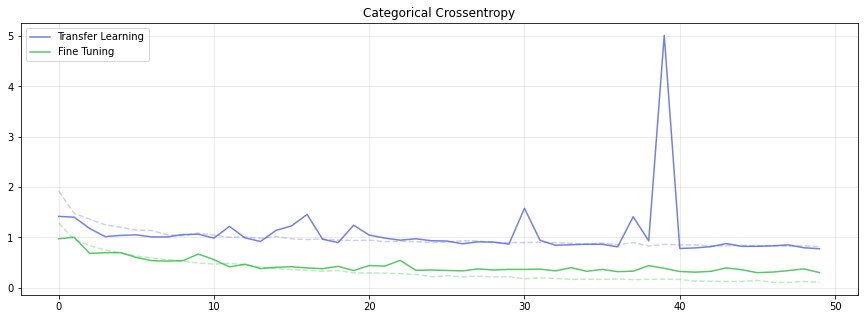

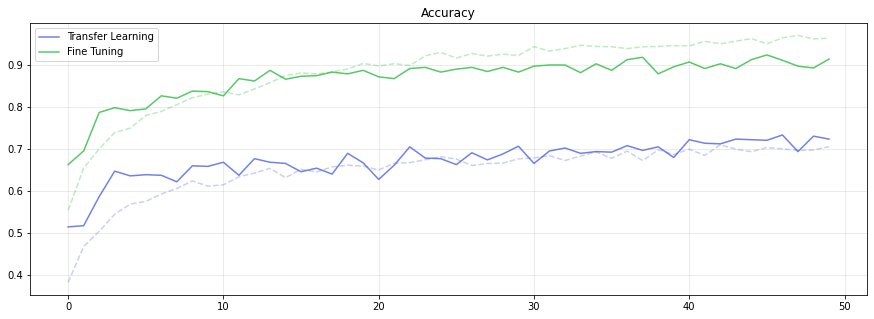

In [ ]:
# Plot the training
plt.figure(figsize=(15,5))
plt.plot(tl_history['loss'], alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_loss'], label='Transfer Learning', alpha=.8, color='#4D61E2')
plt.plot(ft_history['loss'], alpha=.3, color='#2ABC3D', linestyle='--')
plt.plot(ft_history['val_loss'], label='Fine Tuning', alpha=.8, color='#2ABC3D')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(tl_history['accuracy'], alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_accuracy'], label='Transfer Learning', alpha=.8, color='#4D61E2')
plt.plot(ft_history['accuracy'], alpha=.3, color='#2ABC3D', linestyle='--')
plt.plot(ft_history['val_accuracy'], label='Fine Tuning', alpha=.8, color='#2ABC3D')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [ ]:
ft_model.evaluate(val, return_dict=True)

45/45 [==============================] - 4s 86ms/step - loss: 0.3004 - accuracy: 0.9140


{'loss': 0.3003884255886078, 'accuracy': 0.9139633178710938}

In [ ]:
ft_model.save('Xception_FineTuningModel')

We print also the Confusion Matrix:

In [ ]:
# Re-load the model after transfer learning
ft_model = tfk.models.load_model('Xception_FineTuningModel')

from tqdm import tqdm

y_pred = []
y_true = []
for i in tqdm(range(len(val))):
    data, target = val[i]
    y_pred.extend(list(ft_model.predict(data).argmax(axis=1)))  # predictions as label indices, correct
    y_true.extend(list(target.argmax(axis=1)))

confusion_matrix = tf.math.confusion_matrix(y_true, y_pred).numpy()

  0%|          | 0/45 [00:00<?, ?it/s]

1/1 [==============================] - 9s 9s/step


  2%|▏         | 1/45 [00:09<07:01,  9.58s/it]

1/1 [==============================] - 0s 32ms/step


  4%|▍         | 2/45 [00:16<05:37,  7.85s/it]

1/1 [==============================] - 0s 34ms/step


  7%|▋         | 3/45 [00:22<05:06,  7.30s/it]

1/1 [==============================] - 0s 32ms/step


  9%|▉         | 4/45 [00:29<04:48,  7.03s/it]

1/1 [==============================] - 0s 33ms/step


 11%|█         | 5/45 [00:35<04:28,  6.71s/it]

1/1 [==============================] - 0s 32ms/step


 13%|█▎        | 6/45 [00:41<04:12,  6.47s/it]

1/1 [==============================] - 0s 28ms/step


 16%|█▌        | 7/45 [00:47<03:56,  6.23s/it]

1/1 [==============================] - 0s 29ms/step


 18%|█▊        | 8/45 [00:53<03:49,  6.21s/it]

1/1 [==============================] - 0s 28ms/step


 20%|██        | 9/45 [01:00<03:48,  6.35s/it]

1/1 [==============================] - 0s 28ms/step


 22%|██▏       | 10/45 [01:06<03:45,  6.45s/it]

1/1 [==============================] - 0s 29ms/step


 24%|██▍       | 11/45 [01:13<03:42,  6.55s/it]

1/1 [==============================] - 0s 30ms/step


 27%|██▋       | 12/45 [01:20<03:42,  6.74s/it]

1/1 [==============================] - 0s 33ms/step


 29%|██▉       | 13/45 [01:26<03:29,  6.55s/it]

1/1 [==============================] - 0s 28ms/step


 31%|███       | 14/45 [01:34<03:30,  6.78s/it]

1/1 [==============================] - 0s 32ms/step


 33%|███▎      | 15/45 [01:40<03:23,  6.77s/it]

1/1 [==============================] - 0s 33ms/step


 36%|███▌      | 16/45 [01:45<02:59,  6.18s/it]

1/1 [==============================] - 0s 32ms/step


 38%|███▊      | 17/45 [01:53<03:02,  6.52s/it]

1/1 [==============================] - 0s 30ms/step


 40%|████      | 18/45 [01:59<02:57,  6.59s/it]

1/1 [==============================] - 0s 29ms/step


 42%|████▏     | 19/45 [02:05<02:46,  6.39s/it]

1/1 [==============================] - 0s 29ms/step


 44%|████▍     | 20/45 [02:11<02:33,  6.14s/it]

1/1 [==============================] - 0s 29ms/step


 47%|████▋     | 21/45 [02:18<02:33,  6.39s/it]

1/1 [==============================] - 0s 28ms/step


 49%|████▉     | 22/45 [02:24<02:22,  6.21s/it]

1/1 [==============================] - 0s 30ms/step


 51%|█████     | 23/45 [02:29<02:09,  5.90s/it]

1/1 [==============================] - 0s 30ms/step


 53%|█████▎    | 24/45 [02:36<02:13,  6.36s/it]

1/1 [==============================] - 0s 30ms/step


 56%|█████▌    | 25/45 [02:43<02:12,  6.61s/it]

1/1 [==============================] - 0s 29ms/step


 58%|█████▊    | 26/45 [02:51<02:09,  6.84s/it]

1/1 [==============================] - 0s 32ms/step


 60%|██████    | 27/45 [02:58<02:07,  7.06s/it]

1/1 [==============================] - 0s 31ms/step


 62%|██████▏   | 28/45 [03:06<02:00,  7.12s/it]

1/1 [==============================] - 0s 29ms/step


 64%|██████▍   | 29/45 [03:13<01:56,  7.29s/it]

1/1 [==============================] - 0s 28ms/step


 67%|██████▋   | 30/45 [03:20<01:44,  6.97s/it]

1/1 [==============================] - 0s 29ms/step


 69%|██████▉   | 31/45 [03:26<01:36,  6.88s/it]

1/1 [==============================] - 0s 29ms/step


 71%|███████   | 32/45 [03:33<01:28,  6.84s/it]

1/1 [==============================] - 0s 29ms/step


 73%|███████▎  | 33/45 [03:40<01:21,  6.77s/it]

1/1 [==============================] - 0s 30ms/step


 76%|███████▌  | 34/45 [03:47<01:15,  6.87s/it]

1/1 [==============================] - 0s 28ms/step


 78%|███████▊  | 35/45 [03:54<01:08,  6.87s/it]

1/1 [==============================] - 0s 29ms/step


 80%|████████  | 36/45 [04:01<01:02,  6.93s/it]

1/1 [==============================] - 0s 29ms/step


 82%|████████▏ | 37/45 [04:08<00:56,  7.09s/it]

1/1 [==============================] - 0s 29ms/step


 84%|████████▍ | 38/45 [04:16<00:51,  7.31s/it]

1/1 [==============================] - 0s 29ms/step


 87%|████████▋ | 39/45 [04:23<00:43,  7.22s/it]

1/1 [==============================] - 0s 29ms/step


 89%|████████▉ | 40/45 [04:29<00:33,  6.78s/it]

1/1 [==============================] - 0s 28ms/step


 91%|█████████ | 41/45 [04:36<00:27,  6.86s/it]

1/1 [==============================] - 0s 29ms/step


 93%|█████████▎| 42/45 [04:42<00:20,  6.71s/it]

1/1 [==============================] - 0s 29ms/step


 96%|█████████▌| 43/45 [04:48<00:13,  6.57s/it]

1/1 [==============================] - 0s 29ms/step


 98%|█████████▊| 44/45 [04:55<00:06,  6.47s/it]

1/1 [==============================] - 1s 722ms/step


100%|██████████| 45/45 [04:57<00:00,  6.62s/it]


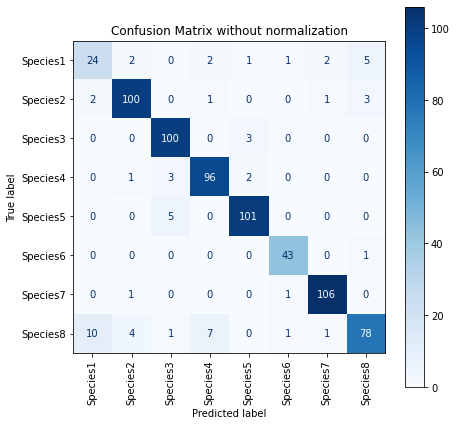

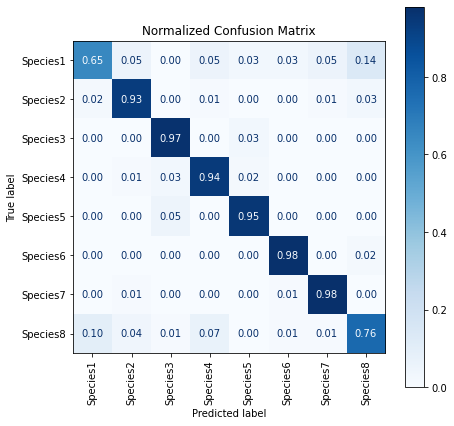

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

fig, ax = plt.subplots(figsize=(7,7))
disp = ConfusionMatrixDisplay(confusion_matrix, display_labels=labels)
disp.plot(ax=ax, xticks_rotation='vertical', values_format='d',cmap='Blues')
plt.title("Confusion Matrix without normalization")
plt.show()

fig, ax = plt.subplots(figsize=(7,7))
cmn = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]
disp = ConfusionMatrixDisplay(cmn, display_labels=labels)
disp.plot(ax=ax, xticks_rotation='vertical', values_format='.2f',cmap='Blues')
plt.title("Normalized Confusion Matrix")
plt.show()

#A few other attempts

For the sake of completeness we leave here some of our failed attempts..

##OverSampling

Since we have very few data of the $1^{st}$ and $6^{st}$ Species w.r.t. the others, we decide to oversample the minority class of a factor 3 in the training set. In this way, we obtain more or less the same quantity of images for all the Species.

However, we did not stick with this process because it gives us worst result.

## Discarded Models

We test different models for the task.

#### VGG19 Model:
- Adding a BatchNormalization and Droput layers as written in the code below ("#ADDED"): the plot is fluctuating a lot
- Without those layers it gave us: **'loss': 1.516, 'accuracy': 0.520**

In [ ]:
def build_model(input_shape):
    vgg = tf.keras.applications.VGG19( include_top=False,
                                        weights="imagenet",
                                        input_shape=input_shape
                                        )
    for layer in vgg.layers[:-2]:
        layer.trainable = False
    
    model = tfk.Sequential()
    model.add(vgg)

    model.add(tfkl.Conv2D(128, (3, 3), padding="same"))
    model.add(tfkl.Activation("relu"))
    model.add(tfkl.BatchNormalization(axis=-1))
    model.add(tfkl.MaxPooling2D(pool_size=(2, 2)))
    ##model.add(tfkl.BatchNormalization(axis=-1)) #ADDED!!
    model.add(tfkl.Dropout(0.2, seed=seed))
    model.add(tfkl.Flatten())
    model.add(tfkl.Dense(units=256,kernel_initializer = tfk.initializers.GlorotUniform(seed)))
    ##model.add(tfkl.Dropout(0.5, seed=seed)) #ADDED!!
    model.add(tfkl.Activation("relu"))
    model.add(tfkl.BatchNormalization())
    model.add(tfkl.Dropout(0.2, seed=seed))
    model.add(tfkl.Dense(units=8, activation="softmax",kernel_initializer = tfk.initializers.GlorotUniform(seed)))

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

####InceptionV3 Model

In [ ]:
def build_model(input_shape):
    xcep = tf.keras.applications.InceptionV3( include_top=False,
                                        weights="imagenet",
                                        input_shape=input_shape
                                        )
    for layer in xcep.layers[:-2]:
        layer.trainable = False

    model = tfk.Sequential()
    model.add(xcep)

    model.add(tfkl.Conv2D(128, (3, 3), padding="same"))
    model.add(tfkl.Activation("relu"))
    model.add(tfkl.BatchNormalization(axis=-1))
    model.add(tfkl.MaxPooling2D(pool_size=(2, 2)))
    model.add(tfkl.Dropout(0.2, seed=seed))
    model.add(tfkl.Flatten())
    model.add(tfkl.Dense(units=256,kernel_initializer = tfk.initializers.GlorotUniform(seed)))
    model.add(tfkl.Activation("relu"))
    model.add(tfkl.BatchNormalization())
    model.add(tfkl.Dropout(0.2, seed=seed))
    model.add(tfkl.Dense(units=8, activation="softmax",kernel_initializer = tfk.initializers.GlorotUniform(seed)))

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

In [ ]:
input_shape = (256, 256, 3)

model_IV3 = build_model(input_shape)
model_IV3.summary()

87910968/87910968 [==============================] - 1s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 6, 6, 2048)        21802784  
                                                                 
 conv2d_99 (Conv2D)          (None, 6, 6, 128)         2359424   
                                                                 
 activation_96 (Activation)  (None, 6, 6, 128)         0         
                                                                 
 batch_normalization_100 (Ba  (None, 6, 6, 128)        512       
 tchNormalization)                                               
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 3, 3, 128)        0         
 2D)                                                             
                                                       

In [ ]:
epochs = 50

history = model_IV3.fit(
    x=train,
    epochs = epochs,
    validation_data = val,
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True)]
).history

Epoch 1/50
178/178 [==============================] - 55s 282ms/step - loss: 1.8395 - accuracy: 0.3830 - val_loss: 1.5153 - val_accuracy: 0.4937
Epoch 2/50
178/178 [==============================] - 48s 269ms/step - loss: 1.4406 - accuracy: 0.4882 - val_loss: 1.3238 - val_accuracy: 0.5515
Epoch 3/50
178/178 [==============================] - 49s 274ms/step - loss: 1.3640 - accuracy: 0.5097 - val_loss: 1.2409 - val_accuracy: 0.5585
Epoch 4/50
178/178 [==============================] - 48s 268ms/step - loss: 1.2499 - accuracy: 0.5443 - val_loss: 1.0807 - val_accuracy: 0.6164
Epoch 5/50
178/178 [==============================] - 48s 271ms/step - loss: 1.2218 - accuracy: 0.5574 - val_loss: 1.0508 - val_accuracy: 0.6319
Epoch 6/50
178/178 [==============================] - 47s 264ms/step - loss: 1.2038 - accuracy: 0.5584 - val_loss: 1.0677 - val_accuracy: 0.6375
Epoch 7/50
178/178 [==============================] - 48s 269ms/step - loss: 1.1331 - accuracy: 0.5888 - val_loss: 1.1943 - val_ac

In [ ]:
model_IV3.evaluate(val, return_dict=True)

45/45 [==============================] - 2s 42ms/step - loss: 0.9115 - accuracy: 0.6855


{'loss': 0.9115176796913147, 'accuracy': 0.6854724884033203}

This model gave us worsen result in the validation accuracy compared to the one of the Xception Model

##Modello Xception:

We try using Xception with and without a few layers added and we try changing the classifier (SVM and Quasi-SVM):

In [ ]:
def build_model(input_shape):
    xcep = tf.keras.applications.Xception( include_top=False,
                                        weights="imagenet",
                                        input_shape=input_shape
                                        )
    
    model = tfk.Sequential()
    model.add(xcep)

    model.add(tfkl.Conv2D(128, (3, 3), padding="same"))
    model.add(tfkl.Activation("relu"))
    model.add(tfkl.BatchNormalization(axis=-1))
    model.add(tfkl.MaxPooling2D(pool_size=(2, 2)))
    #model.add(tfkl.BatchNormalization(axis=-1)) #ADDED!!
    model.add(tfkl.Dropout(0.2, seed=seed))
    model.add(tfkl.Flatten())
    model.add(tfkl.Dense(units=256,kernel_initializer = tfk.initializers.GlorotUniform(seed)))
    #model.add(tfkl.Dropout(0.5, seed=seed)) #ADDED!! #cambiare 0.5 in quacosa di meno!
    model.add(tfkl.Activation("relu"))
    model.add(tfkl.BatchNormalization())
    model.add(tfkl.Dropout(0.2, seed=seed))
    model.add(tfkl.Dense(units=8, activation="softmax",kernel_initializer = tfk.initializers.GlorotUniform(seed)))

    #Try to add SVM classifier:
    #model.add(tfkl.Dense(8,kernel_regularizer = tf.keras.regularizers.L2(0.001),activation= "softmax"))
    #model.compile(optimizer="adam",loss="squared_hinge", metrics = ['accuracy'])

    #Try Quasi-SVM:
    #model.add(tf.keras.layers.experimental.RandomFourierFeatures(output_dim=2048, scale=10.0, kernel_initializer="gaussian"))
    #model.add(tfkl.Dense(units=8, activation="softmax",kernel_initializer = tfk.initializers.GlorotUniform(seed)))

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

In [ ]:
input_shape = (256, 256, 3)

# Build model
model = build_model(input_shape)
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 8, 8, 2048)        20861480  
                                                                 
 dense_11 (Dense)            (None, 8, 8, 512)         1049088   
                                                                 
 activation_14 (Activation)  (None, 8, 8, 512)         0         
                                                                 
 batch_normalization_46 (Bat  (None, 8, 8, 512)        2048      
 chNormalization)                                                
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 4, 4, 512)        0         
 2D)                                                             
                                                                 
 dropout_14 (Dropout)        (None, 4, 4, 512)        

Since the class are unbalanced, we use class_weights for weighting the loss function (during training only), in this way the model "pay more attention" to samples from an under-represented class.
However, this has not given us better perfomances.

In [ ]:
#from sklearn.utils.class_weight import compute_class_weight
#class_weights = compute_class_weight(class_weight = "balanced", classes= np.unique(train.classes), y= train.classes)
#class_weight = dict(zip(np.unique(train.classes), class_weights))
#class_weight

{0: 2.376677852348993,
 1: 0.8332352941176471,
 2: 0.8595266990291263,
 3: 0.8658312958435208,
 4: 0.8332352941176471,
 5: 1.9894662921348314,
 6: 0.8254662004662005,
 7: 0.8722290640394089}

In [ ]:
epochs = 50

history = model.fit(
    x=train,
    epochs = epochs,
    validation_data = val,
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True)]
).history

Epoch 1/50
178/178 [==============================] - 92s 471ms/step - loss: 1.8869 - accuracy: 0.3886 - val_loss: 22.1345 - val_accuracy: 0.2863
Epoch 2/50
178/178 [==============================] - 83s 464ms/step - loss: 1.4674 - accuracy: 0.4963 - val_loss: 5.7100 - val_accuracy: 0.3639
Epoch 3/50
178/178 [==============================] - 82s 458ms/step - loss: 1.1981 - accuracy: 0.5838 - val_loss: 1.0864 - val_accuracy: 0.6276
Epoch 4/50
178/178 [==============================] - 83s 467ms/step - loss: 1.0386 - accuracy: 0.6417 - val_loss: 0.7794 - val_accuracy: 0.7447
Epoch 5/50
178/178 [==============================] - 82s 459ms/step - loss: 0.9191 - accuracy: 0.6908 - val_loss: 0.7173 - val_accuracy: 0.7602
Epoch 6/50
178/178 [==============================] - 82s 462ms/step - loss: 0.8153 - accuracy: 0.7222 - val_loss: 0.9097 - val_accuracy: 0.7236
Epoch 7/50
178/178 [==============================] - 83s 464ms/step - loss: 0.8417 - accuracy: 0.7158 - val_loss: 0.6003 - val_a

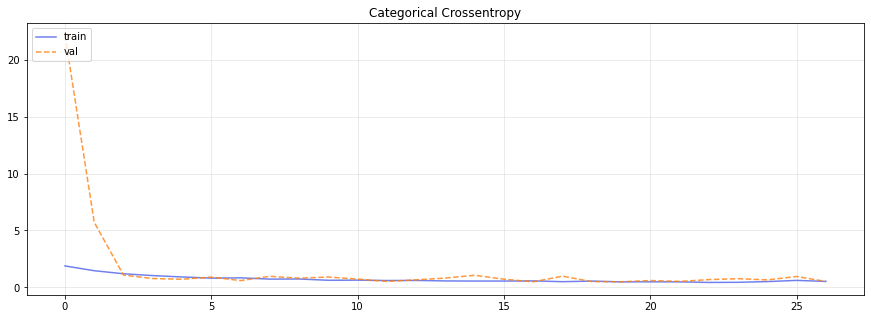

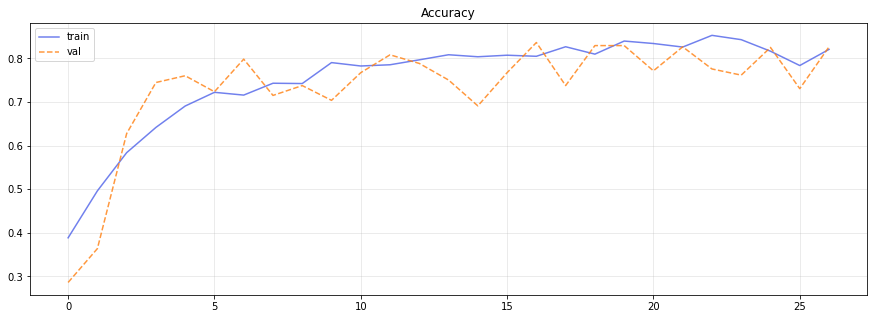

In [ ]:
# Plot the training
plt.figure(figsize=(15,5))
plt.plot(history['loss'],label='train', alpha=.8, color='#4d61e9')
plt.plot(history['val_loss'], label='val', alpha=.8, color='#ff7f0e', linestyle='--')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history['accuracy'], label='train', alpha=.8, color='#4d61e9')
plt.plot(history['val_accuracy'], label='val', alpha=.8, color='#ff7f0e', linestyle='--')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [ ]:
model.evaluate(val, return_dict=True)

45/45 [==============================] - 4s 87ms/step - loss: 0.4961 - accuracy: 0.8364


{'loss': 0.4961155652999878, 'accuracy': 0.8363893032073975}


- With row added: ***loss: 0.8606 - accuracy: 0.7179***
- Without row added: ***loss: 0.8397 - accuracy: 0.7264 --> REAL = 0.6659***
- SVM and Quasi-SVM as classifier but did not give us nice results

##Hyperparameter Tunings su TF:

We try to tune the hyperparameters of our neural network by changing the rate of the dropout Layers, the units of the Dense Layer and the learning rate of the Adam Optimizers:

In [ ]:
def build_model(input_shape):
    supernet.trainable=False
    
    model = tfk.Sequential()
    model.add(supernet)

    model.add(tfkl.Conv2D(128, (3, 3), padding="same"))


    model.add(tfkl.Activation("relu"))
    model.add(tfkl.BatchNormalization(axis=-1))
    model.add(tfkl.MaxPooling2D(pool_size=(2, 2)))
    
    #RATES1:
    rates1=input_shape.Float("rates1",min_value=0.1, max_value=0.4,step=0.1)
    model.add(tfkl.Dropout(rate=rates1))

    model.add(tfkl.Flatten())

    #UNITS:
    model.add(tfkl.Dense(
            units=input_shape.Int("units", min_value=32, max_value=512, step=32),
            kernel_initializer = tfk.initializers.GlorotUniform(seed),
        ))
    
    model.add(tfkl.Activation("relu"))
    model.add(tfkl.BatchNormalization())
    
    #RATES2:
    rates2=input_shape.Float("rates2",min_value=0.1, max_value=0.4,step=0.1)
    model.add(tfkl.Dropout(rate=rates2))

    model.add(tfkl.Dense(units=8, activation="softmax",kernel_initializer = tfk.initializers.GlorotUniform(seed)))

    # Compile the model
    #LR:
    learning_rate = input_shape.Float("lr", min_value=1e-5, max_value=1e-2, sampling="log")
    model.compile(
        optimizer=tfk.optimizers.Adam(learning_rate=learning_rate),
        loss="CategoricalCrossentropy",
        metrics=["accuracy"],
    )

    # Return the model
    return model

In [ ]:
!pip install keras-tuner -q

     |████████████████████████████████| 135 kB 14.8 MB/s 
     |████████████████████████████████| 1.6 MB 55.6 MB/s 


Due to the limited runtime of the free-GPU on Colab we set the number of trials to 15 and execution per trials to 2.

In [ ]:
import keras_tuner

tuner = keras_tuner.RandomSearch(
    hypermodel=build_model,
    objective="val_accuracy",
    max_trials=15,
    executions_per_trial=2,
    overwrite=True
)

In [ ]:
tuner.search_space_summary()

Search space summary
Default search space size: 4
rates1 (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.4, 'step': 0.1, 'sampling': None}
units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
rates2 (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.4, 'step': 0.1, 'sampling': None}
lr (Float)
{'default': 1e-05, 'conditions': [], 'min_value': 1e-05, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


In [ ]:
tuner.search(train, epochs=15, validation_data=val)

Trial 15 Complete [00h 27m 49s]
val_accuracy: 0.6868829429149628

Best val_accuracy So Far: 0.705923855304718
Total elapsed time: 07h 22m 05s


The best val_accuracy reached is bu setting the hyperparameters in the following way:

1.   rates1 = 0.2
2.   units = 320
3.   rates2 = 0.3
4.   lr = 0.00030587

However this gives a validation accuracy of 0.7059 that is worse than our best model so far (with rates1 and rates2 of 0.2, units of 256 and lr of 0.001).



##Fine Tuning until layer 33:

In [ ]:
ft_model = tfk.models.load_model('XceptionTransferLearningModel')
ft_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 8, 8, 2048)        20861480  
                                                                 
 conv2d_5 (Conv2D)           (None, 8, 8, 128)         2359424   
                                                                 
 activation_2 (Activation)   (None, 8, 8, 128)         0         
                                                                 
 batch_normalization_6 (Batc  (None, 8, 8, 128)        512       
 hNormalization)                                                 
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 4, 4, 128)        0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 4, 4, 128)        

In [ ]:
# Set all Xception layers to True
ft_model.get_layer('xception').trainable = True
for i, layer in enumerate(ft_model.get_layer('xception').layers):
   print(i, layer.name, layer.trainable)

0 input_1 True
1 block1_conv1 True
2 block1_conv1_bn True
3 block1_conv1_act True
4 block1_conv2 True
5 block1_conv2_bn True
6 block1_conv2_act True
7 block2_sepconv1 True
8 block2_sepconv1_bn True
9 block2_sepconv2_act True
10 block2_sepconv2 True
11 block2_sepconv2_bn True
12 conv2d True
13 block2_pool True
14 batch_normalization True
15 add True
16 block3_sepconv1_act True
17 block3_sepconv1 True
18 block3_sepconv1_bn True
19 block3_sepconv2_act True
20 block3_sepconv2 True
21 block3_sepconv2_bn True
22 conv2d_1 True
23 block3_pool True
24 batch_normalization_1 True
25 add_1 True
26 block4_sepconv1_act True
27 block4_sepconv1 True
28 block4_sepconv1_bn True
29 block4_sepconv2_act True
30 block4_sepconv2 True
31 block4_sepconv2_bn True
32 conv2d_2 True
33 block4_pool True
34 batch_normalization_2 True
35 add_2 True
36 block5_sepconv1_act True
37 block5_sepconv1 True
38 block5_sepconv1_bn True
39 block5_sepconv2_act True
40 block5_sepconv2 True
41 block5_sepconv2_bn True
42 block5_sep

In [ ]:
for i, layer in enumerate(ft_model.get_layer('xception').layers[:33]):
  layer.trainable=False

for i, layer in enumerate(ft_model.get_layer('xception').layers):
   print(i, layer.name, layer.trainable)
ft_model.summary()

0 input_1 False
1 block1_conv1 False
2 block1_conv1_bn False
3 block1_conv1_act False
4 block1_conv2 False
5 block1_conv2_bn False
6 block1_conv2_act False
7 block2_sepconv1 False
8 block2_sepconv1_bn False
9 block2_sepconv2_act False
10 block2_sepconv2 False
11 block2_sepconv2_bn False
12 conv2d False
13 block2_pool False
14 batch_normalization False
15 add False
16 block3_sepconv1_act False
17 block3_sepconv1 False
18 block3_sepconv1_bn False
19 block3_sepconv2_act False
20 block3_sepconv2 False
21 block3_sepconv2_bn False
22 conv2d_1 False
23 block3_pool False
24 batch_normalization_1 False
25 add_1 False
26 block4_sepconv1_act False
27 block4_sepconv1 False
28 block4_sepconv1_bn False
29 block4_sepconv2_act False
30 block4_sepconv2 False
31 block4_sepconv2_bn False
32 conv2d_2 False
33 block4_pool True
34 batch_normalization_2 True
35 add_2 True
36 block5_sepconv1_act True
37 block5_sepconv1 True
38 block5_sepconv1_bn True
39 block5_sepconv2_act True
40 block5_sepconv2 True
41 bloc

In [ ]:
# Compile the model
ft_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-4), metrics='accuracy')

In [ ]:
# Fine-tune the model
ft_history = ft_model.fit(
    x = train,
    epochs = epochs,
    validation_data = val,
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True)]
).history

Epoch 1/50
178/178 [==============================] - 69s 358ms/step - loss: 1.3035 - accuracy: 0.5429 - val_loss: 0.9518 - val_accuracy: 0.6417
Epoch 2/50
178/178 [==============================] - 64s 357ms/step - loss: 0.9403 - accuracy: 0.6622 - val_loss: 0.8042 - val_accuracy: 0.7221
Epoch 3/50
178/178 [==============================] - 63s 353ms/step - loss: 0.8307 - accuracy: 0.7070 - val_loss: 0.7302 - val_accuracy: 0.7518
Epoch 4/50
178/178 [==============================] - 62s 345ms/step - loss: 0.7574 - accuracy: 0.7339 - val_loss: 0.7330 - val_accuracy: 0.7800
Epoch 5/50
178/178 [==============================] - 63s 351ms/step - loss: 0.7161 - accuracy: 0.7451 - val_loss: 0.7075 - val_accuracy: 0.7842
Epoch 6/50
178/178 [==============================] - 62s 349ms/step - loss: 0.6395 - accuracy: 0.7744 - val_loss: 0.5696 - val_accuracy: 0.8124
Epoch 7/50
178/178 [==============================] - 61s 340ms/step - loss: 0.6295 - accuracy: 0.7836 - val_loss: 0.6022 - val_ac

In [ ]:
ft_model.evaluate(val, return_dict=True)

45/45 [==============================] - 4s 88ms/step - loss: 0.3056 - accuracy: 0.9097


{'loss': 0.3055659532546997, 'accuracy': 0.9097320437431335}